In [1]:
import pandas as pd 
df_tweets = pd.read_csv('tweets.csv')
df_tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Spoke to Governor @GavinNewsom early this morn...,03-06-2020 15:47:58,5196,18674,False,1235955288064135168
1,Twitter for iPhone,It is FAKE NEWS that @HHSGov @SecAzar is “side...,03-06-2020 15:38:06,6191,22710,False,1235952805581447173
2,Twitter for iPhone,I will protect your Social Security and Medica...,03-06-2020 15:08:07,14742,62389,False,1235945259370041344
3,Twitter for iPhone,https://t.co/QvDKY27t6h https://t.co/FenhyvcdBC,03-06-2020 15:03:25,5201,19348,False,1235944077188665344
4,Twitter for iPhone,JOBS JOBS JOBS!!! https://t.co/x0olZd3RLu,03-06-2020 14:21:18,13468,53720,False,1235933477092159489


##  Data Pre-processing 

In [2]:
from nltk.corpus import stopwords 
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:10]

["it's", 'as', 'yourselves', 'i', 'all', 'more', 'own', 'it', 'nor', "wasn't"]

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
import re
import math 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/achintya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Defining the preprocessing function  
from clean_tweets import clean_tweets
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/achintya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,preprocessed_text,tokenized_text
0,Twitter for iPhone,Spoke to Governor @GavinNewsom early this morn...,03-06-2020 15:47:58,5196,18674,False,1235955288064135168,spoke governor @gavinnewsom early morning crui...,"[spoke, governor, gavinnewsom, early, morning,..."
1,Twitter for iPhone,It is FAKE NEWS that @HHSGov @SecAzar is “side...,03-06-2020 15:38:06,6191,22710,False,1235952805581447173,fake news @hhsgov @secazar “sidelined” great j...,"[fake, news, hhsgov, secazar, sidelined, great..."
2,Twitter for iPhone,I will protect your Social Security and Medica...,03-06-2020 15:08:07,14742,62389,False,1235945259370041344,protect social security medicare past 3 years....,"[protect, social, security, medicare, past, ye..."
3,Twitter for iPhone,https://t.co/QvDKY27t6h https://t.co/FenhyvcdBC,03-06-2020 15:03:25,5201,19348,False,1235944077188665344,,[]
4,Twitter for iPhone,JOBS JOBS JOBS!!! https://t.co/x0olZd3RLu,03-06-2020 14:21:18,13468,53720,False,1235933477092159489,jobs jobs jobs!!!,"[jobs, jobs, jobs]"
...,...,...,...,...,...,...,...,...,...
2262,Twitter Web Client,My persona will never be that of a wallflower ...,05-12-2009 14:07:28,1421,1950,False,1773561338,persona never wallflower - i’d rather build wa...,"[persona, never, wallflower, rather, build, wa..."
2263,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...,05-08-2009 20:40:15,8,27,False,1741160716,new blog post: celebrity apprentice finale les...,"[new, blog, post, celebrity, apprentice, final..."
2264,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...,05-08-2009 13:38:08,3,2,False,1737479987,donald trump reads top ten financial tips late...,"[donald, trump, reads, top, ten, financial, ti..."
2265,Twitter Web Client,Donald Trump will be appearing on The View tom...,05-05-2009 01:00:10,2,3,False,1701461182,donald trump appearing view tomorrow morning d...,"[donald, trump, appearing, view, tomorrow, mor..."


In [7]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet], 10)

[('realdonaldtrump', 349),
 ('trump', 289),
 ('president', 289),
 ('great', 282),
 ('democrats', 210),
 ('impeachment', 184),
 ('thank', 148),
 ('people', 134),
 ('new', 129),
 ('house', 126)]

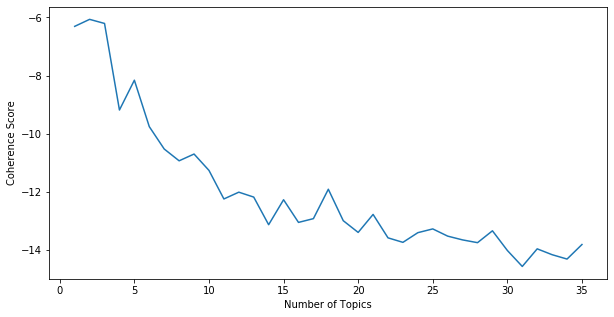

In [9]:
# build a dicionary where for each tweet, each word has its own id 
# we have 2267 tweets
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet 
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute the coherence 
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics=nb_topics, id2word=tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)
    
import matplotlib.pyplot as plt

# visualize coherence 
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

### Running LDA 

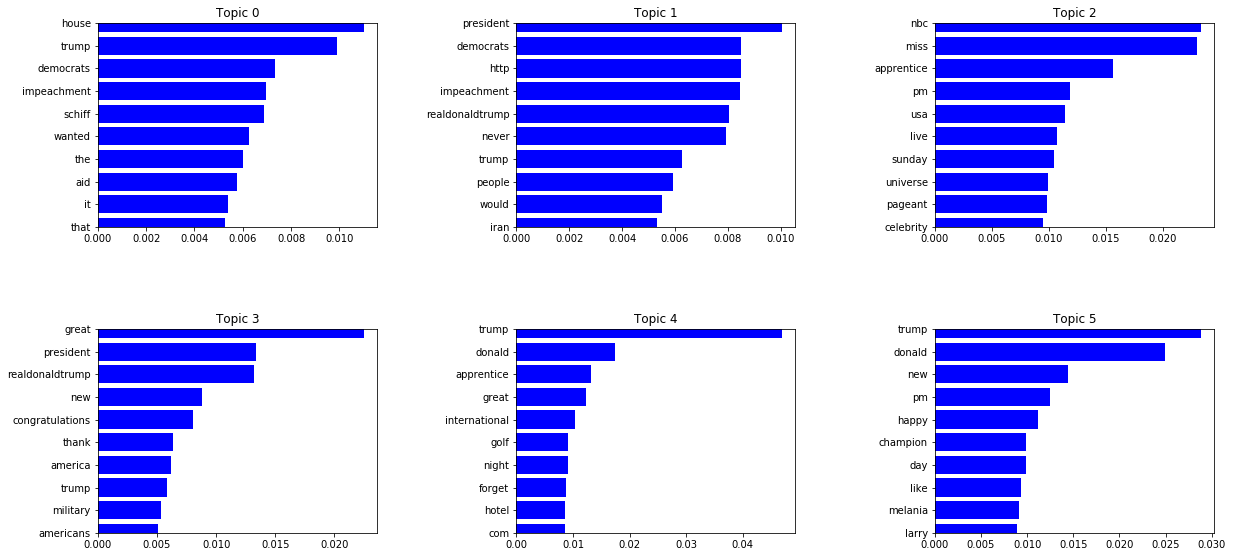

In [11]:
from matplotlib import gridspec

k = 6
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
plot_top_words()